# Robomed

In [1]:
%matplotlib inline

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin

## Args

In [2]:
TRAIN_PATH = '~/.kaggle/competitions/ai-hack-2018-spb-robomed/train_data.csv'
TEST_PATH = '~/.kaggle/competitions/ai-hack-2018-spb-robomed/test_data.csv'
SUBMISSION_PATH = 'submission.csv'
MODEL_SAVE_PATH = 'model.pkl'

## Read

In [3]:
def initial_pre(df):
    df = df.copy()
    del df['ID']
    rename_map = {
        'Код_диагноза': 'diag_code',
        'Диагноз': 'diag',
        'Возраст': 'age',
        'Пол': 'sex',
        'Общее состояние': 'state',
        'аллергия': 'allergies',
        'Анамнез заболевания': 'anamnesis',
        'Внешний осмотр': 'checkup',
        'Revisit': 'revisit'
    }
    return df.rename(columns=rename_map)

In [4]:
df = initial_pre(pd.read_csv(TRAIN_PATH))
len(df)

283086

In [5]:
df.head()

,diag_code,diag,age,sex,state,allergies,anamnesis,checkup,revisit
0,J06.0,Острый ларингофарингит,29,2,NaN,NaN,NaN,На жевательной поверхности 2.6- кариозная поло...,1
1,N76.1,Подострый и хронический вагинит,45,2,NaN,NaN,считает себя больной на протяжении многих лет....,NaN,1
2,L23.9,"Аллергический контактный дерматит, причина не ...",63,2,NaN,NaN,"Болен около 2-х дней, когда появились описанны...",NaN,1
3,N48.1,Баланопостит,43,2,NaN,не отягощен,NaN,NaN,1
4,Z00.0,Общий медицинский осмотр,29,1,NaN,NaN,провела полное обследование для оперативного л...,NaN,1


In [6]:
df.describe(include='all')

,diag_code,diag,age,sex,state,allergies,anamnesis,checkup,revisit
count,283086,283086,283086.000000,283086.000000,41696,40908,203656,13295,283086.000000
unique,3437,3394,NaN,NaN,2942,5141,152589,779,NaN
top,N77.1*,"Вагинит, вульвит и вульвовагинит при инфекцион...",NaN,NaN,Общее самочувствие удовлетворительное. Кожные ...,не отягощен,консультация по проведенному обследованию и ко...,удовлетворительное.,NaN
freq,11214,11214,NaN,NaN,8960,17361,3025,6622,NaN
mean,NaN,NaN,41.696905,1.708347,NaN,NaN,NaN,NaN,0.828639
std,NaN,NaN,21.540704,0.454524,NaN,NaN,NaN,NaN,0.376825
min,NaN,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,31.000000,1.000000,NaN,NaN,NaN,NaN,1.000000
50%,NaN,NaN,38.000000,2.000000,NaN,NaN,NaN,NaN,1.000000
75%,NaN,NaN,51.000000,2.000000,NaN,NaN,NaN,NaN,1.000000


In [7]:
df.dtypes

diag_code    object
diag         object
age           int64
sex           int64
state        object
allergies    object
anamnesis    object
checkup      object
revisit       int64
dtype: object

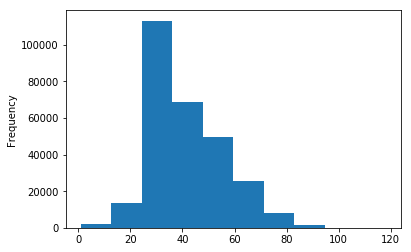

In [8]:
age = df.age.copy()
age[age > 120] = None
age.plot('hist');

## Test analysis

In [9]:
tdf = initial_pre(pd.read_csv(TEST_PATH))
tdf.head()

,diag_code,diag,age,sex,state,allergies,anamnesis,checkup
0,Z39.2,Рутинное послеродовое наблюдение,41,2,Общее самочувствие удовлетворительное. Кожные ...,Аллергию на лекарства - отрицает.,NaN,NaN
1,M54.2,Цервикалгия,64,2,NaN,не отягощен,NaN,NaN
2,M41,Сколиоз,34,2,"Удовлетворительное. Температура тела - 36,6. С...",NaN,NaN,NaN
3,J31.2,Хронический фарингит,58,2,NaN,NaN,NaN,Общее состояние удовлетворительное. Конфигурац...
4,M21.4,Плоская стопа [pes planus] (приобретенная),34,2,NaN,NaN,Жалобы сегодня с утра,NaN


In [10]:
df.sex.value_counts()

2    200523
1     82563
Name: sex, dtype: int64

In [11]:
tdf.sex.value_counts()

2    66391
1    33609
Name: sex, dtype: int64

## Preprocess

### Only `anamnesis`

In [12]:
# def make_textclf_data(df, balance=False):
#     X, y = df.anamnesis.fillna(''), df.revisit
    
#     if balance:
#         n = y.value_counts().min()
#         y0, y1 = y[y == 0].sample(n), y[y == 1].sample(n)
#         X0, X1 = X[y0.index], X[y1.index]
#         X, y = pd.concat([X0, X1], axis=0).sample(frac=1), pd.concat([y0, y1], axis=0).sample(frac=1)
    
#     return X, y

### Features

In [13]:
def parse_diag_code(diag_code, 
                    dc_pattern=re.compile('([A-Z])?([0-9][0-9])?(\.([0-9]))?')):
    m = dc_pattern.match(diag_code)
    letter, code, subcode = m.group(1), m.group(2), m.group(4)
    code = int(code) if code is not None else None
    subcode = int(subcode) if subcode is not None else None
    return letter, code, subcode


# def get_age_group(age):
#     if age > 120:
#         return None
# #     df.age.as_matrix()[:, np.newaxis].shape
#     return 0

In [14]:
class FFTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, sex_1d=None):
        self.sex_1d = sex_1d
    
    def fit(self, df):
        return self
    
    def transform(self, df):
        df = df.copy()
        
        if self.sex_1d:
            n = int((df.sex == 1).sum() / self.sex_1d)
            df1 = df[df.sex == 1]
            df2 = df[df.sex == 2].sample(n)
            df = pd.concat([df1, df2], axis=0)
    
        features = []
        # diag_code
        features.append(pd.DataFrame(list(df.diag_code.apply(parse_diag_code)), 
                                     columns=['letter', 'code', 'subcode'],
                                     dtype=object, index=df.index))
        
        # diag
        features.append(df[['diag']])

        # age
        df.age = df.age.astype(float)
        df.loc[df.age > 120, 'age'] = np.nan
        features.append(df[['age']])

        # sex
        features.append(df[['sex']])

        # state, allergies, checkup, -anamnesis
        features.append(df[['state', 'allergies', 'checkup']])

        data = pd.concat(features, axis=1)
        data = data.apply(lambda c: c.fillna('NaN') if (c.dtype == object) else c)
        if 'revisit' in df:
            data = (data, df.revisit)

        return data

In [15]:
ff = FFTransformer()
X, y = ff.fit_transform(df)
X.head()

,letter,code,subcode,diag,age,sex,state,allergies,checkup
0,J,6,0,Острый ларингофарингит,29.0,2,NaN,NaN,На жевательной поверхности 2.6- кариозная поло...
1,N,76,1,Подострый и хронический вагинит,45.0,2,NaN,NaN,NaN
2,L,23,9,"Аллергический контактный дерматит, причина не ...",63.0,2,NaN,NaN,NaN
3,N,48,1,Баланопостит,43.0,2,NaN,не отягощен,NaN
4,Z,0,0,Общий медицинский осмотр,29.0,1,NaN,NaN,NaN


In [16]:
X.dtypes

letter        object
code           int64
subcode       object
diag          object
age          float64
sex            int64
state         object
allergies     object
checkup       object
dtype: object

In [17]:
y.dtype

dtype('int64')

## TT split

In [18]:
preprocess = FFTransformer()
X, y = preprocess.fit_transform(df)
cat_features = np.where(X.dtypes != np.float)[0]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05)
X_test = preprocess.transform(tdf)
X_train.shape, X_val.shape, X_test.shape

((268931, 9), (14155, 9), (100000, 9))

## Scipy

In [19]:
# from sklearn.pipeline import Pipeline
# from sklearn.linear_model import SGDClassifier
# from sklearn.neural_network import MLPClassifier
# from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [20]:
# model = Pipeline([
#     ('vec', TfidfVectorizer(ngram_range=(1, 3), max_features=1000)),
#     ('clf', MLPClassifier(hidden_layer_sizes=(300, 300, 2))),
#  ])

In [21]:
# %time model.fit(X_train, y_train)

In [22]:
# y_pred = model.predict(X_test)
# (y_pred == y_test).sum() / len(y_test)

In [23]:
# roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

## Keras

https://gist.github.com/madrugado/63c068b52a135c6fdbbb6fe17acbc0c8

In [24]:
# from keras.preprocessing.text import Tokenizer

In [25]:
# tokenizer = Tokenizer(num_words=1000)
# tokenizer.fit_on_texts(X_train)

In [26]:
# X_train = tokenizer.texts_to_matrix(X_train, mode='binary')
# X_test = tokenizer.texts_to_matrix(X_test, mode='binary')
# X_train.shape, X_test.shape

## CatBoost

https://tech.yandex.com/catboost/doc/dg/concepts/parameter-tuning-docpage/

In [27]:
import catboost as cb

In [28]:
model = cb.CatBoostClassifier(depth=6)
model.fit(X_train, y_train, cat_features=cat_features, 
          use_best_model=True, eval_set=(X_val, y_val), 
          plot=False);

0:	learn: 0.6757743	test: 0.6752926	best: 0.6752926 (0)	total: 218ms	remaining: 3m 37s
1:	learn: 0.6595907	test: 0.6586615	best: 0.6586615 (1)	total: 327ms	remaining: 2m 43s
2:	learn: 0.6444915	test: 0.6431402	best: 0.6431402 (2)	total: 483ms	remaining: 2m 40s
3:	learn: 0.6304283	test: 0.6286953	best: 0.6286953 (3)	total: 616ms	remaining: 2m 33s
4:	learn: 0.6173495	test: 0.6153004	best: 0.6153004 (4)	total: 750ms	remaining: 2m 29s
5:	learn: 0.6051549	test: 0.6028226	best: 0.6028226 (5)	total: 883ms	remaining: 2m 26s
6:	learn: 0.5938428	test: 0.5912644	best: 0.5912644 (6)	total: 1.02s	remaining: 2m 25s
7:	learn: 0.5834089	test: 0.5808261	best: 0.5808261 (7)	total: 1.21s	remaining: 2m 29s
8:	learn: 0.5736034	test: 0.5710090	best: 0.5710090 (8)	total: 1.33s	remaining: 2m 26s
9:	learn: 0.5643810	test: 0.5617916	best: 0.5617916 (9)	total: 1.42s	remaining: 2m 20s
10:	learn: 0.5559172	test: 0.5533381	best: 0.5533381 (10)	total: 1.55s	remaining: 2m 19s
11:	learn: 0.5479526	test: 0.5453917	best

94:	learn: 0.4153668	test: 0.4153727	best: 0.4153727 (94)	total: 12.1s	remaining: 1m 55s
95:	learn: 0.4152770	test: 0.4152747	best: 0.4152747 (95)	total: 12.2s	remaining: 1m 54s
96:	learn: 0.4151948	test: 0.4152144	best: 0.4152144 (96)	total: 12.3s	remaining: 1m 54s
97:	learn: 0.4151318	test: 0.4151551	best: 0.4151551 (97)	total: 12.5s	remaining: 1m 54s
98:	learn: 0.4150541	test: 0.4150710	best: 0.4150710 (98)	total: 12.6s	remaining: 1m 54s
99:	learn: 0.4149883	test: 0.4150091	best: 0.4150091 (99)	total: 12.8s	remaining: 1m 54s
100:	learn: 0.4149243	test: 0.4149487	best: 0.4149487 (100)	total: 12.9s	remaining: 1m 54s
101:	learn: 0.4148151	test: 0.4148620	best: 0.4148620 (101)	total: 13.1s	remaining: 1m 55s
102:	learn: 0.4147669	test: 0.4148357	best: 0.4148357 (102)	total: 13.3s	remaining: 1m 55s
103:	learn: 0.4147227	test: 0.4147917	best: 0.4147917 (103)	total: 13.4s	remaining: 1m 55s
104:	learn: 0.4146734	test: 0.4147518	best: 0.4147518 (104)	total: 13.6s	remaining: 1m 55s
105:	learn:

186:	learn: 0.4120119	test: 0.4130169	best: 0.4130169 (186)	total: 26.9s	remaining: 1m 56s
187:	learn: 0.4119955	test: 0.4130096	best: 0.4130096 (187)	total: 27s	remaining: 1m 56s
188:	learn: 0.4119771	test: 0.4129877	best: 0.4129877 (188)	total: 27.2s	remaining: 1m 56s
189:	learn: 0.4119581	test: 0.4129716	best: 0.4129716 (189)	total: 27.4s	remaining: 1m 56s
190:	learn: 0.4119360	test: 0.4129656	best: 0.4129656 (190)	total: 27.6s	remaining: 1m 56s
191:	learn: 0.4119210	test: 0.4129554	best: 0.4129554 (191)	total: 27.8s	remaining: 1m 56s
192:	learn: 0.4119079	test: 0.4129490	best: 0.4129490 (192)	total: 27.9s	remaining: 1m 56s
193:	learn: 0.4118800	test: 0.4129366	best: 0.4129366 (193)	total: 28.1s	remaining: 1m 56s
194:	learn: 0.4118400	test: 0.4129182	best: 0.4129182 (194)	total: 28.2s	remaining: 1m 56s
195:	learn: 0.4118248	test: 0.4129059	best: 0.4129059 (195)	total: 28.4s	remaining: 1m 56s
196:	learn: 0.4118093	test: 0.4129013	best: 0.4129013 (196)	total: 28.6s	remaining: 1m 56s
1

277:	learn: 0.4108640	test: 0.4125452	best: 0.4125430 (273)	total: 42.6s	remaining: 1m 50s
278:	learn: 0.4108543	test: 0.4125330	best: 0.4125330 (278)	total: 42.8s	remaining: 1m 50s
279:	learn: 0.4108450	test: 0.4125298	best: 0.4125298 (279)	total: 42.9s	remaining: 1m 50s
280:	learn: 0.4108397	test: 0.4125289	best: 0.4125289 (280)	total: 43.1s	remaining: 1m 50s
281:	learn: 0.4108305	test: 0.4125238	best: 0.4125238 (281)	total: 43.3s	remaining: 1m 50s
282:	learn: 0.4108222	test: 0.4125257	best: 0.4125238 (281)	total: 43.5s	remaining: 1m 50s
283:	learn: 0.4108157	test: 0.4125266	best: 0.4125238 (281)	total: 43.6s	remaining: 1m 49s
284:	learn: 0.4108076	test: 0.4125244	best: 0.4125238 (281)	total: 43.8s	remaining: 1m 49s
285:	learn: 0.4108014	test: 0.4125200	best: 0.4125200 (285)	total: 43.9s	remaining: 1m 49s
286:	learn: 0.4107931	test: 0.4125129	best: 0.4125129 (286)	total: 44.1s	remaining: 1m 49s
287:	learn: 0.4107826	test: 0.4125056	best: 0.4125056 (287)	total: 44.2s	remaining: 1m 49s

369:	learn: 0.4101562	test: 0.4122230	best: 0.4122230 (369)	total: 58.7s	remaining: 1m 39s
370:	learn: 0.4101464	test: 0.4122132	best: 0.4122132 (370)	total: 58.8s	remaining: 1m 39s
371:	learn: 0.4101357	test: 0.4122059	best: 0.4122059 (371)	total: 59s	remaining: 1m 39s
372:	learn: 0.4101341	test: 0.4122064	best: 0.4122059 (371)	total: 59.2s	remaining: 1m 39s
373:	learn: 0.4101277	test: 0.4122016	best: 0.4122016 (373)	total: 59.4s	remaining: 1m 39s
374:	learn: 0.4101252	test: 0.4122035	best: 0.4122016 (373)	total: 59.6s	remaining: 1m 39s
375:	learn: 0.4101172	test: 0.4122019	best: 0.4122016 (373)	total: 59.7s	remaining: 1m 39s
376:	learn: 0.4101135	test: 0.4121984	best: 0.4121984 (376)	total: 59.9s	remaining: 1m 39s
377:	learn: 0.4101080	test: 0.4122008	best: 0.4121984 (376)	total: 1m	remaining: 1m 38s
378:	learn: 0.4101035	test: 0.4122001	best: 0.4121984 (376)	total: 1m	remaining: 1m 38s
379:	learn: 0.4100972	test: 0.4121950	best: 0.4121950 (379)	total: 1m	remaining: 1m 38s
380:	learn

459:	learn: 0.4095499	test: 0.4120671	best: 0.4120664 (457)	total: 1m 14s	remaining: 1m 26s
460:	learn: 0.4095473	test: 0.4120691	best: 0.4120664 (457)	total: 1m 14s	remaining: 1m 26s
461:	learn: 0.4095443	test: 0.4120686	best: 0.4120664 (457)	total: 1m 14s	remaining: 1m 26s
462:	learn: 0.4095408	test: 0.4120684	best: 0.4120664 (457)	total: 1m 14s	remaining: 1m 26s
463:	learn: 0.4095349	test: 0.4120620	best: 0.4120620 (463)	total: 1m 14s	remaining: 1m 26s
464:	learn: 0.4095299	test: 0.4120562	best: 0.4120562 (464)	total: 1m 14s	remaining: 1m 26s
465:	learn: 0.4095262	test: 0.4120523	best: 0.4120523 (465)	total: 1m 14s	remaining: 1m 25s
466:	learn: 0.4095235	test: 0.4120488	best: 0.4120488 (466)	total: 1m 15s	remaining: 1m 25s
467:	learn: 0.4095191	test: 0.4120473	best: 0.4120473 (467)	total: 1m 15s	remaining: 1m 25s
468:	learn: 0.4095123	test: 0.4120493	best: 0.4120473 (467)	total: 1m 15s	remaining: 1m 25s
469:	learn: 0.4095043	test: 0.4120483	best: 0.4120473 (467)	total: 1m 15s	remain

549:	learn: 0.4090477	test: 0.4119319	best: 0.4119315 (542)	total: 1m 29s	remaining: 1m 13s
550:	learn: 0.4090430	test: 0.4119302	best: 0.4119302 (550)	total: 1m 29s	remaining: 1m 13s
551:	learn: 0.4090388	test: 0.4119270	best: 0.4119270 (551)	total: 1m 30s	remaining: 1m 13s
552:	learn: 0.4090336	test: 0.4119255	best: 0.4119255 (552)	total: 1m 30s	remaining: 1m 12s
553:	learn: 0.4090241	test: 0.4119192	best: 0.4119192 (553)	total: 1m 30s	remaining: 1m 12s
554:	learn: 0.4090206	test: 0.4119202	best: 0.4119192 (553)	total: 1m 30s	remaining: 1m 12s
555:	learn: 0.4090169	test: 0.4119172	best: 0.4119172 (555)	total: 1m 30s	remaining: 1m 12s
556:	learn: 0.4090140	test: 0.4119164	best: 0.4119164 (556)	total: 1m 30s	remaining: 1m 12s
557:	learn: 0.4090090	test: 0.4119227	best: 0.4119164 (556)	total: 1m 31s	remaining: 1m 12s
558:	learn: 0.4090080	test: 0.4119209	best: 0.4119164 (556)	total: 1m 31s	remaining: 1m 11s
559:	learn: 0.4090035	test: 0.4119199	best: 0.4119164 (556)	total: 1m 31s	remain

639:	learn: 0.4086261	test: 0.4117863	best: 0.4117863 (639)	total: 1m 46s	remaining: 59.8s
640:	learn: 0.4086244	test: 0.4117858	best: 0.4117858 (640)	total: 1m 46s	remaining: 59.6s
641:	learn: 0.4086160	test: 0.4117798	best: 0.4117798 (641)	total: 1m 46s	remaining: 59.4s
642:	learn: 0.4086111	test: 0.4117723	best: 0.4117723 (642)	total: 1m 46s	remaining: 59.3s
643:	learn: 0.4086093	test: 0.4117743	best: 0.4117723 (642)	total: 1m 46s	remaining: 59.1s
644:	learn: 0.4086049	test: 0.4117725	best: 0.4117723 (642)	total: 1m 47s	remaining: 58.9s
645:	learn: 0.4086020	test: 0.4117730	best: 0.4117723 (642)	total: 1m 47s	remaining: 58.8s
646:	learn: 0.4085963	test: 0.4117766	best: 0.4117723 (642)	total: 1m 47s	remaining: 58.6s
647:	learn: 0.4085914	test: 0.4117762	best: 0.4117723 (642)	total: 1m 47s	remaining: 58.5s
648:	learn: 0.4085880	test: 0.4117753	best: 0.4117723 (642)	total: 1m 47s	remaining: 58.3s
649:	learn: 0.4085838	test: 0.4117748	best: 0.4117723 (642)	total: 1m 47s	remaining: 58.1s

730:	learn: 0.4082314	test: 0.4116976	best: 0.4116976 (730)	total: 2m 2s	remaining: 45.2s
731:	learn: 0.4082255	test: 0.4116977	best: 0.4116976 (730)	total: 2m 2s	remaining: 45s
732:	learn: 0.4082142	test: 0.4116976	best: 0.4116976 (732)	total: 2m 3s	remaining: 44.8s
733:	learn: 0.4082117	test: 0.4116963	best: 0.4116963 (733)	total: 2m 3s	remaining: 44.7s
734:	learn: 0.4082089	test: 0.4116965	best: 0.4116963 (733)	total: 2m 3s	remaining: 44.5s
735:	learn: 0.4082061	test: 0.4116970	best: 0.4116963 (733)	total: 2m 3s	remaining: 44.3s
736:	learn: 0.4081997	test: 0.4116880	best: 0.4116880 (736)	total: 2m 3s	remaining: 44.2s
737:	learn: 0.4081950	test: 0.4116873	best: 0.4116873 (737)	total: 2m 3s	remaining: 44s
738:	learn: 0.4081889	test: 0.4116897	best: 0.4116873 (737)	total: 2m 4s	remaining: 43.8s
739:	learn: 0.4081871	test: 0.4116892	best: 0.4116873 (737)	total: 2m 4s	remaining: 43.7s
740:	learn: 0.4081776	test: 0.4116872	best: 0.4116872 (740)	total: 2m 4s	remaining: 43.5s
741:	learn: 0.

821:	learn: 0.4077997	test: 0.4116202	best: 0.4116175 (820)	total: 2m 19s	remaining: 30.2s
822:	learn: 0.4077961	test: 0.4116185	best: 0.4116175 (820)	total: 2m 19s	remaining: 30s
823:	learn: 0.4077894	test: 0.4116155	best: 0.4116155 (823)	total: 2m 19s	remaining: 29.8s
824:	learn: 0.4077835	test: 0.4116090	best: 0.4116090 (824)	total: 2m 19s	remaining: 29.7s
825:	learn: 0.4077785	test: 0.4116119	best: 0.4116090 (824)	total: 2m 20s	remaining: 29.5s
826:	learn: 0.4077732	test: 0.4116092	best: 0.4116090 (824)	total: 2m 20s	remaining: 29.4s
827:	learn: 0.4077667	test: 0.4116122	best: 0.4116090 (824)	total: 2m 20s	remaining: 29.2s
828:	learn: 0.4077639	test: 0.4116113	best: 0.4116090 (824)	total: 2m 20s	remaining: 29s
829:	learn: 0.4077608	test: 0.4116098	best: 0.4116090 (824)	total: 2m 20s	remaining: 28.8s
830:	learn: 0.4077584	test: 0.4116088	best: 0.4116088 (830)	total: 2m 21s	remaining: 28.7s
831:	learn: 0.4077533	test: 0.4116147	best: 0.4116088 (830)	total: 2m 21s	remaining: 28.5s
832

913:	learn: 0.4074131	test: 0.4115413	best: 0.4115413 (913)	total: 2m 36s	remaining: 14.8s
914:	learn: 0.4074047	test: 0.4115368	best: 0.4115368 (914)	total: 2m 36s	remaining: 14.6s
915:	learn: 0.4074000	test: 0.4115380	best: 0.4115368 (914)	total: 2m 37s	remaining: 14.4s
916:	learn: 0.4073924	test: 0.4115349	best: 0.4115349 (916)	total: 2m 37s	remaining: 14.2s
917:	learn: 0.4073886	test: 0.4115356	best: 0.4115349 (916)	total: 2m 37s	remaining: 14.1s
918:	learn: 0.4073821	test: 0.4115411	best: 0.4115349 (916)	total: 2m 37s	remaining: 13.9s
919:	learn: 0.4073782	test: 0.4115414	best: 0.4115349 (916)	total: 2m 37s	remaining: 13.7s
920:	learn: 0.4073760	test: 0.4115414	best: 0.4115349 (916)	total: 2m 38s	remaining: 13.6s
921:	learn: 0.4073735	test: 0.4115407	best: 0.4115349 (916)	total: 2m 38s	remaining: 13.4s
922:	learn: 0.4073678	test: 0.4115380	best: 0.4115349 (916)	total: 2m 38s	remaining: 13.2s
923:	learn: 0.4073642	test: 0.4115364	best: 0.4115349 (916)	total: 2m 38s	remaining: 13.1s

## Analysis

In [29]:
roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])

0.7135426484666363

In [30]:
model.get_params()

{'depth': 6, 'loss_function': 'Logloss'}

In [31]:
def draw_importance(columns, importances, top_k=20, save_path=None):
    order = np.argsort(importances)[-top_k:]
    
    objects = columns[order]
    y_pos = np.arange(len(objects))
    performance = np.array(importances)[order]

    plt.figure(figsize=(20, 10))
    plt.barh(y_pos, performance, align='center', alpha=0.5)
    plt.yticks(y_pos, objects)
    plt.xlabel('Importance')
    plt.title('Feature')

    if save_path:
        plt.savefig(save_path)
    plt.show()

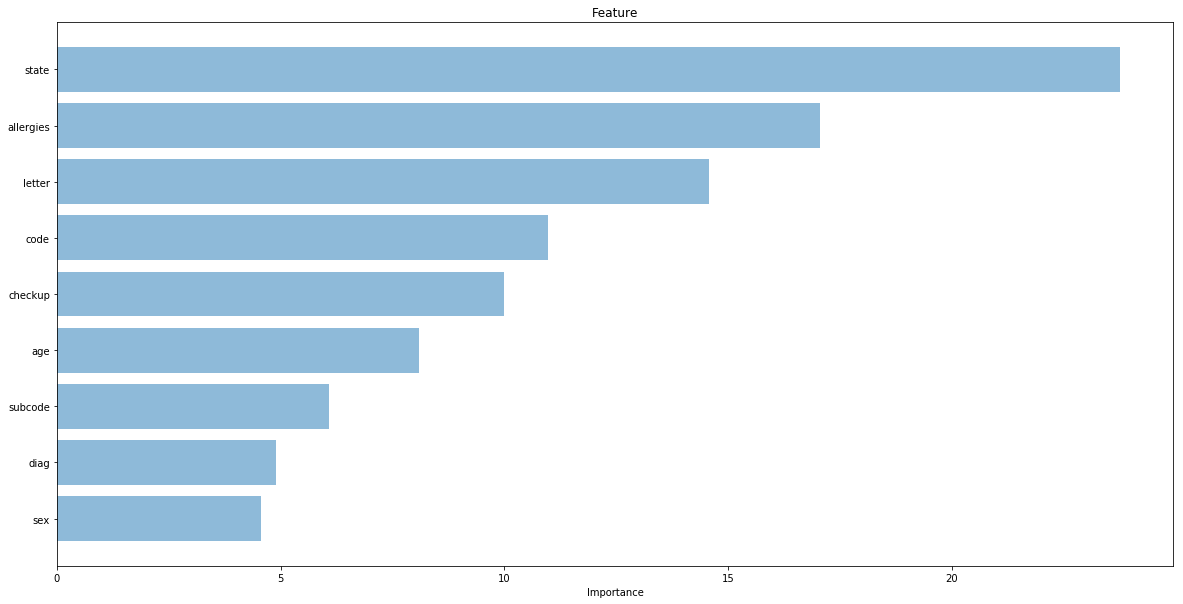

In [32]:
draw_importance(X_train.columns, model.feature_importances_, save_path=None)

## Submission

In [33]:
sdf = pd.DataFrame(tdf.index, columns=['ID'])
sdf['proba'] = model.predict_proba(X_test)[:, 1]
sdf.head()

,ID,proba
0,0,0.880593
1,1,0.885849
2,2,0.724907
3,3,0.954250
4,4,0.676304


In [34]:
sdf.to_csv(SUBMISSION_PATH, index=False)